In [2]:
%matplotlib inline

import sys
import datetime
import random
import math

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import Quandl
import numpy as np
from sklearn import linear_model as lm
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import tree
from sklearn.grid_search import GridSearchCV

from utils import utils as ut
from utils import quandl as ql
from utils import composite
from utils import maps
from settings import TARGET_SERIES, TARGET_INDICATOR

sns.set_style("dark")

/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [68]:
tar = ql.load_target()
tar = tar[datetime.date(1999,1,1):]
PANEL_SCORE = True

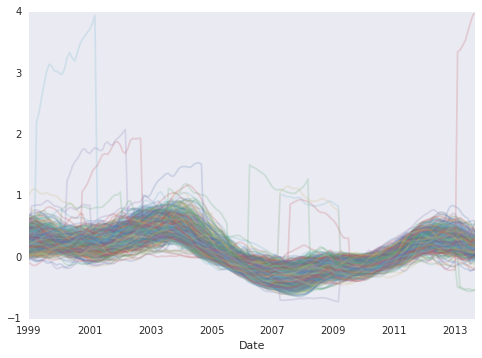

In [69]:
tar.plot(legend=False, alpha=.2)

## increasing values

In [27]:
series = 'IV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(224, 605) (224, 605)


## decreasing values

In [28]:
series = 'DV'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(224, 605) (224, 605)


## ratio sales price to list price

In [34]:
series = 'SLPR'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(77, 270) (77, 270)


## turnover in housing market in past year

In [66]:
series = 'SPY'
px, px_ca, px_us = ql.load_series(series)
print(px.shape, px.dropna().shape)
#composite.explore_series(px, px_ca, px_us, tar)

(213, 766) (213, 766)


## sold for gain

In [39]:
yoy = lambda x: x / x.shift(24) - 1.

In [40]:
series = 'SFG'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

SFG_c = px
#composite.explore_series(px, px_ca, px_us, tar)

(213, 13) (189, 13)


# price per square foot

In [41]:
series = 'MVSF'
px, px_ca, px_us = ql.load_series(series)
px, px_ca, px_us = ut.capped_transformation(yoy, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

#composite.explore_series(px, px_ca, px_us, tar)
MVSF_c = px
#composite.explore_series(px, px_ca, px_us, tar)

(234, 705) (210, 705)


# momentum

In [62]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(ut.momentum, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom = px
#composite.explore_series(px, px_ca, px_us, tar)

(222, 693) (222, 693)


# change in momentum

In [60]:
def momentum_change(df):
    mom_cur = ut.momentum(df)
    mom_prev = ut.momentum(df.shift(12))
    return (mom_cur - mom_prev).dropna(how='all')

In [61]:
px, px_ca, px_us = ql.load_series(TARGET_SERIES)
px, px_ca, px_us = ut.capped_transformation(momentum_change, px, px_ca, px_us)
print(px.shape, px.dropna().shape)

TAR_mom_chg = px
#composite.explore_series(px, px_ca, px_us, tar)

(210, 693) (210, 693)


## build model

In [201]:
features = {}
for i in ('IV', 'DV', 'SPY'):#, 'SLPR'):
    px = ql.load_quandl_data(TARGET_INDICATOR, i)
    px = (px.fillna(method='ffill', limit=3).dropna(axis=1))
    features[i] = px
features['tar'] = tar
# features['SFG'] = SFG_c
# features['MVSF'] = MVSF_c
features['TAR_mom'] = TAR_mom
features['TAR_mom_chg'] = TAR_mom_chg

df = ut.stack_and_align(features.values(), cols=features.keys()).dropna()
df.index.levels[1].name = 'code'

In [202]:
print(df.IV.unstack().dropna(how='all').shape)
print(df.DV.unstack().dropna(how='all').shape)
print(df.SPY.unstack().dropna(how='all').shape)
#print(df.SLPR.unstack().dropna(how='all').shape)

print(df.tar.unstack().dropna(how='all').shape)

# print(df.SFG.unstack().dropna(how='all').shape)
# print(df.MVSF.unstack().dropna(how='all').shape)
print(df.TAR_mom.unstack().dropna(how='all').shape)
print(df.TAR_mom_chg.unstack().dropna(how='all').shape)

(177, 582)
(177, 582)
(177, 582)
(177, 582)
(177, 582)
(177, 582)


In [203]:
for c in df.columns:
    df[c] = ut.xs_z_score_winsorize(df[c].unstack()).stack()

In [204]:
def gen_mkt_movement(df):
    px, px_ca, px_us = ql.load_series(TARGET_SERIES)

    def expand_series_change(s, per):
        s = s.div(s.shift(per))
        return pd.DataFrame(np.repeat(np.array([s.values]).T, repeats=df.ix[:,0].unstack().shape[1], axis=1),
                            columns=df.ix[:,0].unstack().columns,
                            index=s.index)
    
    short = expand_series_change(px_ca, 6)
    med = expand_series_change(px_ca, 12)
    long = expand_series_change(px_ca, 24)
    
    mkt = ut.stack_and_align([short, med, long], cols=['short', 'med', 'long'])
    return mkt.ix[df.index]

mkt = gen_mkt_movement(df)

df = df.merge(mkt, left_index=True, right_index=True)

In [205]:
# def drop_crisis(df):
#     return (df[:datetime.datetime(2005,1,1)]
#             .append(df[datetime.datetime(2009,1,1):]))

# df = drop_crisis(df)

In [206]:
df.head()

TAR_mom     SPY     IV       tar     DV  TAR_mom_chg  \
Date       code                                                           
1999-01-31 00002  0.007725  6.4005  84.81  0.233103  11.63     0.003889   
           00007  0.007455  6.4144  86.78  0.372979  10.00     0.002064   
           00008  0.010080  6.9175  91.48  0.531514   5.65    -0.001170   
           00010  0.009885  5.6177  92.50  0.443320   5.37     0.001023   
           00026  0.000155  5.8948  49.66  0.116985  37.84     0.001048   

                    short       med      long  
Date       code                                
1999-01-31 00002  1.04385  1.091721  1.146341  
           00007  1.04385  1.091721  1.146341  
           00008  1.04385  1.091721  1.146341  
           00010  1.04385  1.091721  1.146341  
           00026  1.04385  1.091721  1.146341

In [82]:
#sns.pairplot(ut.ts_score(df[[c for c in df.columns if c != 'tar']], panel=PANEL_SCORE))

[mean: -1.41539, std: 1.33218, params: {'alpha': 1.0},
 mean: -1.40911, std: 1.32705, params: {'alpha': 10.0},
 mean: -1.36424, std: 1.29220, params: {'alpha': 100},
 mean: -1.24804, std: 1.22720, params: {'alpha': 1000},
 mean: -1.09242, std: 1.23373, params: {'alpha': 10000},
 mean: -1.05401, std: 1.40433, params: {'alpha': 50000},
 mean: -1.68328, std: 2.59444, params: {'alpha': 10000000}]


Ridge(alpha=50000, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)


r2: 0.367467	xs corr: 0.261754


sharpe ratios:
0.2    3.323198
0.4    3.705267
0.6    3.808615
0.8    3.909441
1.0    3.995475
mkt    4.094733
dtype: float64
int: 0.000000	coef: [ 0.1185347   0.09290445  0.18482727 -0.19075492  0.01739441]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


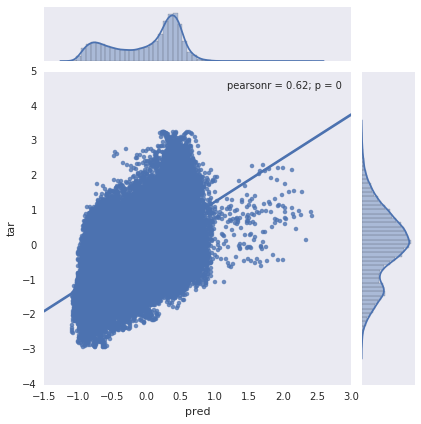

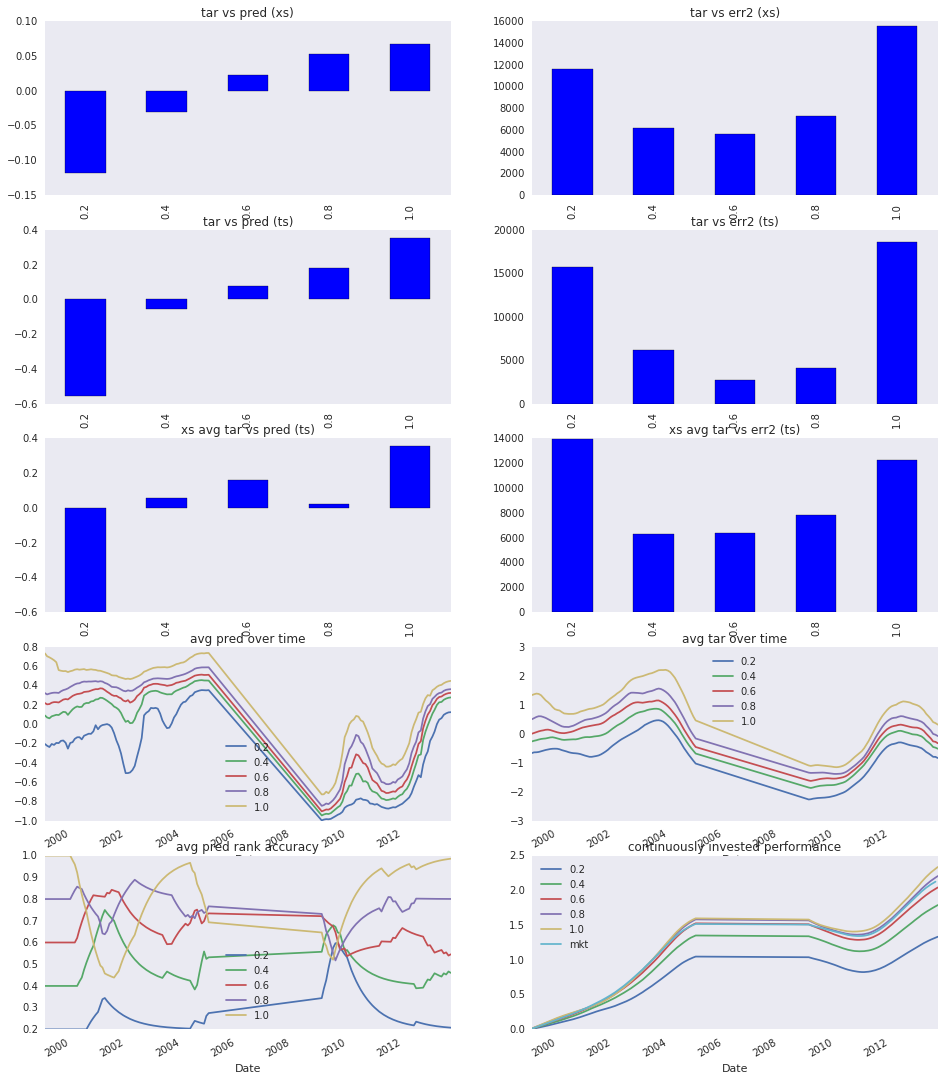

In [113]:
clf = GridSearchCV(lm.Ridge(), param_grid={'alpha': [1., 10., 100, 1000, 10000, 50000, 10000000]}, cv=5, iid=False)
df_ts = ut.ts_score(df, PANEL_SCORE)
clf, df_res, score, pred = composite.build_model(clf, df_ts)
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

In [54]:
pred.reset_index().to_csv('data/processed/pred.csv', index=False)

show prediction in map

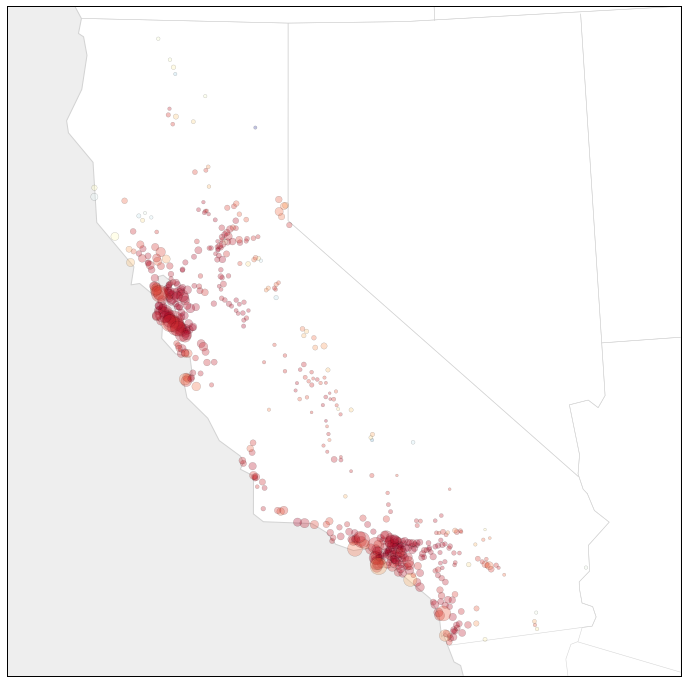

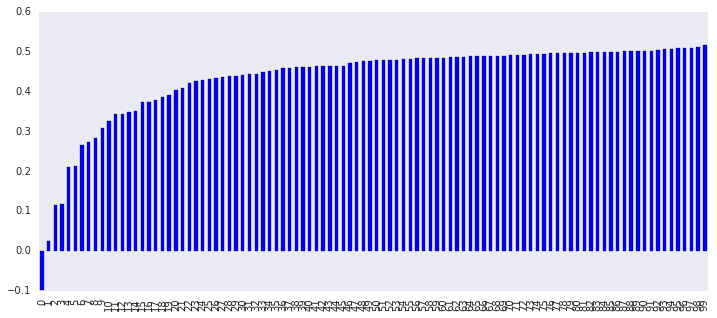

In [44]:
map_pred = maps.load_pred_for_map()
cm = plt.cm.get_cmap('RdYlBu')
m = maps.draw_CA()
row = map_pred.loc[map_pred.index.levels[0][-1]]
style = dict(marker='o', alpha=0.3, zorder=2, latlon=True, label='cities', cmap=cm)
m.scatter(row.lon.values, row.lat.values, s=row.px.map(lambda x: x * .0001).values, c=row.pred.values * -1., **style)
plt.figure()
pd.Series(row.sample(n=100).pred.sort_values().values).plot(kind='bar', figsize=(12,5))

lasso model

[mean: -2.40597, std: 1.19904, params: {'alpha': 0.0001},
 mean: -2.34243, std: 1.17986, params: {'alpha': 0.001},
 mean: -2.25342, std: 1.11251, params: {'alpha': 0.01},
 mean: -2.42840, std: 1.07287, params: {'alpha': 0.1}]


Lasso(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)


r2: 0.324902	xs corr: 0.230208


sharpe ratios:
0.2    1.166054
0.4    1.746932
0.6    1.963387
0.8    2.092692
1.0    2.146345
mkt    1.837238
dtype: float64
int: 0.000000	coef: [-0.01682122 -0.15080751  0.41464113]


/home/condauser/anaconda3/lib/python3.4/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


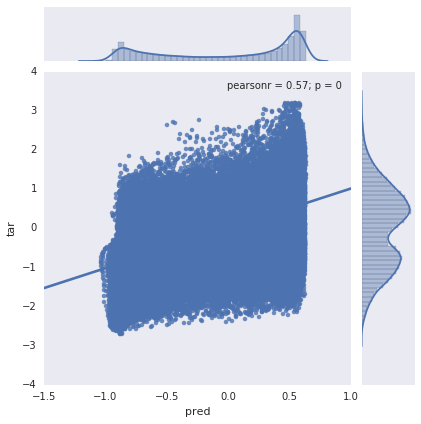

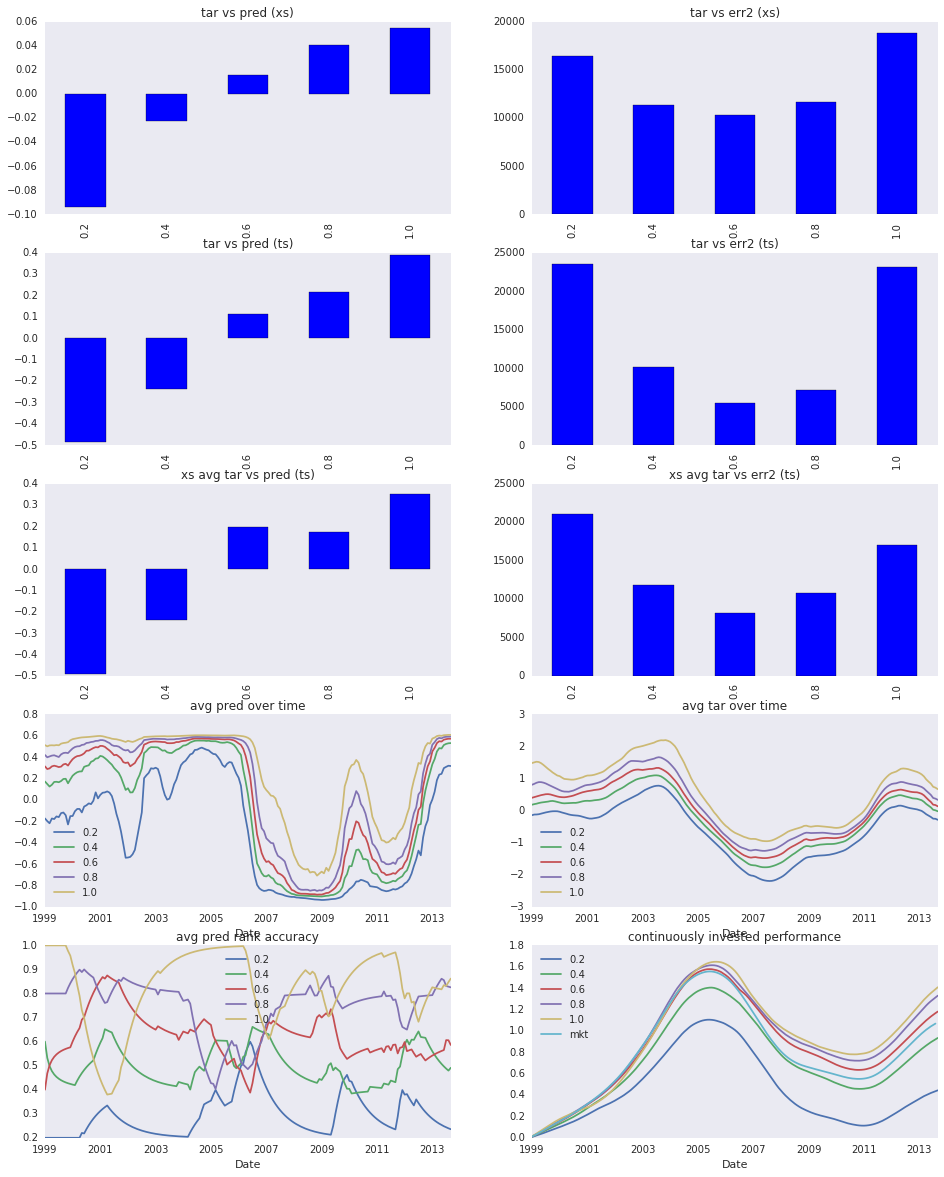

In [55]:
clf = GridSearchCV(lm.Lasso(), param_grid={'alpha': [.0001, .001, .01, .1]}, cv=5, iid=False)
df_ts = ut.ts_score(df, PANEL_SCORE)
clf, df_res, score, pred = composite.build_model(clf, df_ts, PANEL_SCORE)
print('int: {0:03f}\tcoef: {1}'.format(clf.best_estimator_.intercept_, clf.best_estimator_.coef_)) 

In [ ]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), 
                   param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf, df_res, score, pred = composite.build_model(clf, df)

In [ ]:
(pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
 .plot(kind='bar', title='feature importances'))

In [ ]:
# clf = GridSearchCV(GradientBoostingRegressor(), param_grid={'n_estimators': [50, 200],
#                                                             'max_depth': [1,3,5], 
#                                                             'max_features': [None, 1, 2]}, 
#                    cv=5, n_jobs=2, idd=False)
# clf, df_res, score, pred = composite.build_model(clf, df)

In [ ]:
# (pd.Series(clf.best_estimator_.feature_importances_, index=[c for c in df.columns if c != 'tar'])
#  .plot(kind='bar', title='feature importances'))

build model with xs ranked features and targets

In [ ]:
def xs_rank_features(df, skip=('long', 'med', 'short')):
    for c in df.columns if c not in skip:
        df[c] = ut.get_row_percentile(df[c])
    return df
df_r = xs_rank_features(df)

In [ ]:
clf = GridSearchCV(RandomForestRegressor(n_estimators=100), 
                   param_grid={'max_depth': [2,3,5,7], 'max_features': [None, 1, 2,]}, 
                   cv=5, n_jobs=1, iid=False)
clf, df_res, score, pred = composite.build_model(clf, df_r)

build rolling fit model